### DATA605 Project - The Carbon Footprint of Cars: What Drives Emissions?

Importing relevant libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, stats, shapiro, kstest, zscore
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

Connecting to Google Drive workspace

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Merging car model data from 1995 to 2024

In [36]:
file_2024 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my2024-fuel-consumption-ratings.csv', encoding='ISO-8859-1')
file_2023 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my2023-fuel-consumption-ratings.csv', encoding='ISO-8859-1')
file_2022 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my2022-fuel-consumption-ratings.csv', encoding='ISO-8859-1')
file_2021 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my2021-fuel-consumption-ratings.csv', encoding='ISO-8859-1')
file_2020 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my2020-fuel-consumption-ratings.csv', encoding='ISO-8859-1')
file_2015_2019 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my2015-2019-fuel-consumption-ratings.csv', encoding='ISO-8859-1')
file_2005_2014 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my2005-2014-fuel-consumption-ratings-5-cycle.csv', encoding='ISO-8859-1')
file_1995_2004 = pd.read_csv('/content/drive/My Drive/DATA605_Project/my1995-2004-fuel-consumption-ratings-5-cycle.csv', encoding='ISO-8859-1')

files = [file_1995_2004, file_2005_2014, file_2015_2019, file_2020, file_2021, file_2022, file_2023, file_2024]

for df in files:
    if 'CO2.rating' in df.columns:
        df['CO2.rating'] = pd.to_numeric(df['CO2.rating'], errors='coerce')
    if 'Smog.rating' in df.columns:
        df['Smog.rating'] = pd.to_numeric(df['Smog.rating'], errors='coerce')

df = pd.concat(files, ignore_index=True)
df

,Model year,Make,Model,Vehicle class,Engine size (L),Cylinders,Transmission,Fuel type,City (L/100 km),Highway (L/100 km),Combined (L/100 km),Combined (mpg),CO2 emissions (g/km),CO2 rating,Smog rating
0,1995,Acura,Integra,Subcompact,1.8,4,A4,X,11.6,8.3,10.1,28,232,NaN,NaN
1,1995,Acura,Integra,Subcompact,1.8,4,M5,X,11.0,8.3,9.8,29,225,NaN,NaN
2,1995,Acura,Integra GS-R,Subcompact,1.8,4,M5,Z,10.8,8.3,9.7,29,223,NaN,NaN
3,1995,Acura,Legend,Compact,3.2,6,A4,Z,14.2,10.5,12.5,23,288,NaN,NaN
4,1995,Acura,Legend Coupe,Compact,3.2,6,A4,Z,14.6,11.0,13.0,22,299,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27808,2024,Volvo,V60 CC B5 AWD,Station wagon: Small,2.0,4,AS8,Z,10.0,7.5,8.9,32,207,5.0,5.0
27809,2024,Volvo,V90 CC B6 AWD,Station wagon: Mid-size,2.0,4,AS8,Z,10.7,8.1,9.5,30,223,5.0,7.0
27810,2024,Volvo,XC40 B5 AWD,Sport utility vehicle: Small,2.0,4,AS8,Z,9.9,7.8,9.0,31,210,5.0,5.0
27811,2024,Volvo,XC60 B5 AWD,Sport utility vehicle: Small,2.0,4,AS8,Z,10.6,8.3,9.6,29,226,5.0,5.0


Mapping vehicles to broader categories for easier analysis

In [40]:
df['Vehicle class'].unique()

array(['Subcompact', 'Compact', 'Two-seater', 'Station wagon: Small',
       'Minicompact', 'Mid-size', 'Full-size', 'Station wagon: Mid-size',
       'Van: Cargo', 'Van: Passenger', 'Pickup truck: Standard',
       'Sport utility vehicle', 'Minivan', 'Pickup truck: Small',
       'Special purpose vehicle', 'Sport utility vehicle: Small',
       'Sport utility vehicle: Standard'], dtype=object)

In [41]:
category_mapping = {
    'Subcompact': 'Car',
    'Compact': 'Car',
    'Minicompact': 'Car',
    'Mid-size': 'Car',
    'Full-size': 'Car',
    'Two-seater': 'Car',
    'Station wagon: Small': 'Car',
    'Station wagon: Mid-size': 'Car',

    'Sport utility vehicle': 'SUV',
    'Sport utility vehicle: Small': 'SUV',
    'Sport utility vehicle: Standard': 'SUV',

    'Minivan': 'Van',
    'Van: Passenger': 'Van',
    'Van: Cargo': 'Van',

    'Pickup truck: Small': 'Pickup Truck',
    'Pickup truck: Standard': 'Pickup Truck',
}

df['Vehicle category'] = df['Vehicle class'].map(lambda x: category_mapping.get(x, x))

In [42]:
df['Vehicle category'].unique()

array(['Car', 'Van', 'Pickup Truck', 'SUV', 'Special purpose vehicle'],
      dtype=object)

Mapping fuel type codes values to more meaningful labels

In [43]:
df['Fuel type'].unique()

array(['X', 'Z', 'D', 'N', 'E'], dtype=object)

In [44]:
df['Fuel type'] = df['Fuel type'].replace({
    'X': 'Regular Gasoline',
    'Z': 'Premium Gasoline',
    'D': 'Diesel',
    'E': 'E85 Ethanol',
    'N': 'Natural Gas'
})

Checking for missing values in the dataframe

In [45]:
df.isnull().sum()

,0
Model year,0
Make,0
Model,0
Vehicle class,0
Engine size (L),0
Cylinders,0
Transmission,0
Fuel type,0
City (L/100 km),0
Highway (L/100 km),0


To more accurately quantify CO2 emissions, we will focus on the actual CO2 emissions data rather than the CO2 ratings. Additionally, smog emissions is not the target variable for this analysis, so missing values for smog emissions are not a concern in this case. Therefore, I can safely ignore missing data related to these variables.

Analysis

**Q1) Is there any significant difference for CO2 emissions across different fuel types?**

In [46]:
df['Fuel type'].unique()

array(['Regular Gasoline', 'Premium Gasoline', 'Diesel', 'Natural Gas',
       'E85 Ethanol'], dtype=object)

In [47]:
fuel_groups = df.groupby('Fuel type')['CO2 emissions (g/km)']

regular_gasoline_emissions = fuel_groups.get_group('Regular Gasoline')
premium_gasoline_emissions = fuel_groups.get_group('Premium Gasoline')
diesel_emissions = fuel_groups.get_group('Diesel')
natural_gas_emissions = fuel_groups.get_group('Natural Gas')
e85_ethanol_emissions = fuel_groups.get_group('E85 Ethanol')

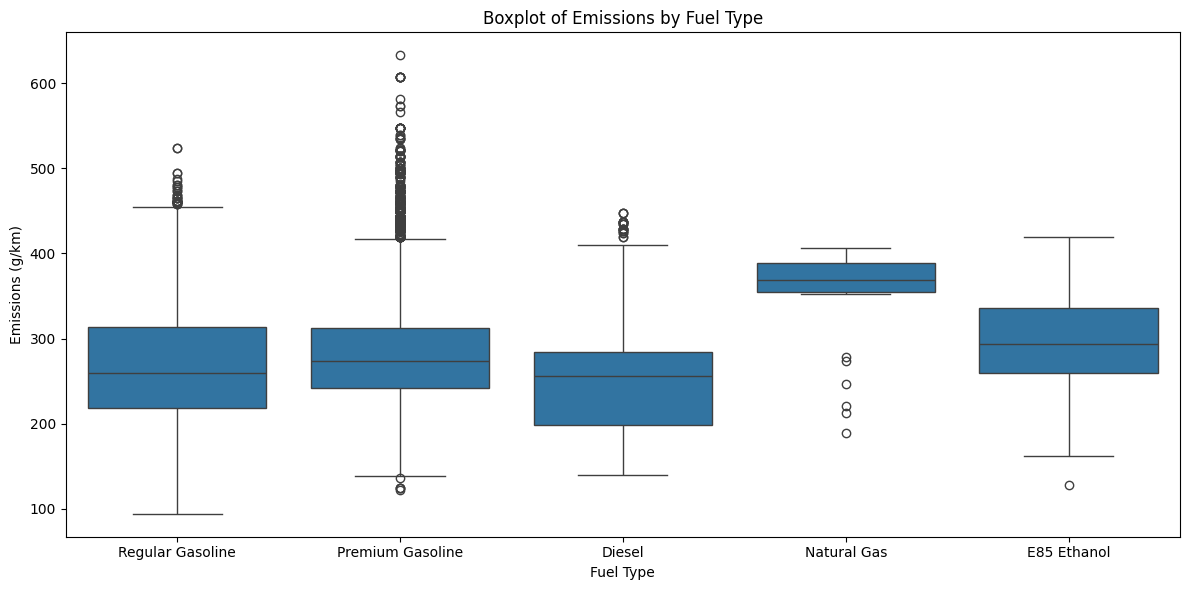

In [66]:
fuel_types = {
    'Regular Gasoline': regular_gasoline_emissions,
    'Premium Gasoline': premium_gasoline_emissions,
    'Diesel': diesel_emissions,
    'Natural Gas': natural_gas_emissions,
    'E85 Ethanol': e85_ethanol_emissions
}

data = []
labels = []

for fuel, emissions in fuel_types.items():
    data.extend(emissions)
    labels.extend([fuel] * len(emissions))

plt.figure(figsize=(12, 6))
sns.boxplot(x=labels, y=data)

plt.xlabel("Fuel Type")
plt.ylabel("Emissions (g/km)")
plt.title("Boxplot of Emissions by Fuel Type")

plt.tight_layout()
plt.show()

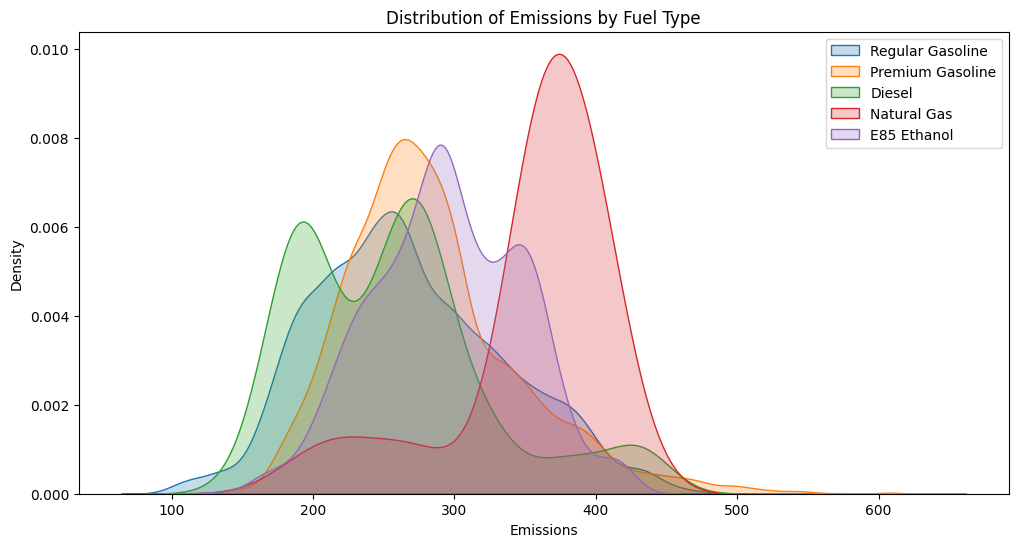

In [48]:
fuel_types = {
    'Regular Gasoline': regular_gasoline_emissions,
    'Premium Gasoline': premium_gasoline_emissions,
    'Diesel': diesel_emissions,
    'Natural Gas': natural_gas_emissions,
    'E85 Ethanol': e85_ethanol_emissions
}

plt.figure(figsize=(12, 6))

for fuel, data in fuel_types.items():
    sns.kdeplot(data, label=fuel, fill=True)

plt.xlabel("Emissions")
plt.ylabel("Density")
plt.title("Distribution of Emissions by Fuel Type")
plt.legend()
plt.show()

We can observe from the distributions that they are not normal and that there is a significant difference between CO2 emissions from different fuel types. Since the distribution of each fuel type is non-normal, we will use the Kruskal-Wallis test, a non-parametric method, to analyze emissions data across fuel types and further validate our analysis.

- **Null Hypothesis (H₀):** There is no difference in emissions between the fuel types (Regular Gasoline, Premium Gasoline, Diesel, Natural Gas, and E85 Ethanol).  

- **Alternative Hypothesis (H₁):** There is a statistically significant difference in emissions between at least two of the fuel types.  

In [49]:
kruskal_test = stats.kruskal(regular_gasoline_emissions, premium_gasoline_emissions, diesel_emissions, natural_gas_emissions, e85_ethanol_emissions)
print(f'Kruskal-Wallis Test p-value: {kruskal_test.pvalue}')

Kruskal-Wallis Test p-value: 1.7139044645850493e-132


<ipython-input-49-1a6c362b52aa>:1: DeprecationWarning:

Please import `kruskal` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.



With a p-value of 1.713e-132, far below our significance level (α=0.05), we reject the null hypothesis that emissions do not differ between fuel types. This result indicates a statistically significant difference in emissions across Regular Gasoline, Premium Gasoline, Diesel, Natural Gas, and E85 Ethanol.

**Q2) How does the fuel efficiency correlate with the CO2 emissions?**

Let's first visualize if there is any potential relationship between the fuel consumption and the amount of CO2 emissions.

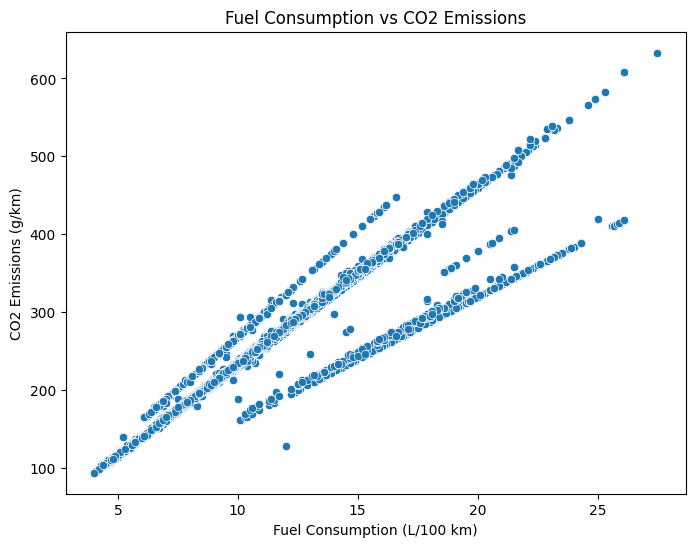

In [62]:
#scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Combined (L/100 km)', y='CO2 emissions (g/km)', data=df)
plt.title('Fuel Consumption vs CO2 Emissions')
plt.xlabel('Fuel Consumption (L/100 km)')
plt.ylabel('CO2 Emissions (g/km)')
plt.show()

Based on the scatterplot, there appears to be a positive linear relationship between fuel efficiency (L/100 km) and CO₂ emissions (g/km). To further investigate and quantify this relationship, we will perform a linear regression analysis.

                             OLS Regression Results                             
Dep. Variable:     CO2 emissions (g/km)   R-squared:                       0.874
Model:                              OLS   Adj. R-squared:                  0.874
Method:                   Least Squares   F-statistic:                 1.924e+05
Date:                  Tue, 11 Feb 2025   Prob (F-statistic):               0.00
Time:                          06:45:14   Log-Likelihood:            -1.2718e+05
No. Observations:                 27813   AIC:                         2.544e+05
Df Residuals:                     27811   BIC:                         2.544e+05
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const         

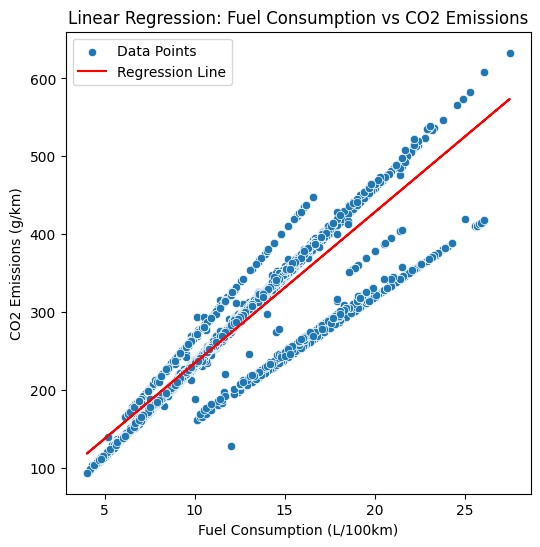

In [63]:
X = df[['Combined (L/100 km)']]
X = sm.add_constant(X)
y = df['CO2 emissions (g/km)']

model = sm.OLS(y, X).fit()
print(model.summary())

#regression line
plt.figure(figsize=(6, 6))
sns.scatterplot(x=df['Combined (L/100 km)'], y=df['CO2 emissions (g/km)'], label='Data Points')
plt.plot(df['Combined (L/100 km)'], model.predict(X), color='red', label='Regression Line')
plt.title('Linear Regression: Fuel Consumption vs CO2 Emissions')
plt.xlabel('Fuel Consumption (L/100km)')
plt.ylabel('CO2 Emissions (g/km)')
plt.legend()
plt.show()

* Our results indicate that the p-value for the Combined_L100km coefficient is 0.000, which is well below the standard significance threshold of 0.05. This confirms that combined fuel consumption (L/100 km) is a statistically significant predictor of CO₂ emissions.

* The coefficient for Combined_L100km is 19.36, meaning that for every 1 L/100 km increase in fuel consumption, CO₂ emissions increase by 19.36 g/km. This strong positive relationship suggests that vehicles with higher fuel consumption tend to produce significantly more CO₂ emissions.

* The R-squared value of 0.874 indicates that 87.4% of the variation in CO₂ emissions can be explained by fuel consumption. This demonstrates a very strong predictive relationship between the two variables.

In [65]:
corr, p_value = pearsonr(df['Combined (L/100 km)'], df['CO2 emissions (g/km)'])
print(f'Pearson correlation coefficient: {corr}')
print(f'p-value: {p_value}')

Pearson correlation coefficient: 0.9347219426518323
p-value: 0.0


To further quantify this relationship, I also computed the Pearson correlation coefficient, which is 0.93. This indicates a strong positive correlation between fuel consumption and CO₂ emissions.

**Question 3) Which vehicle categories are associated with higher or lower pollution levels?**

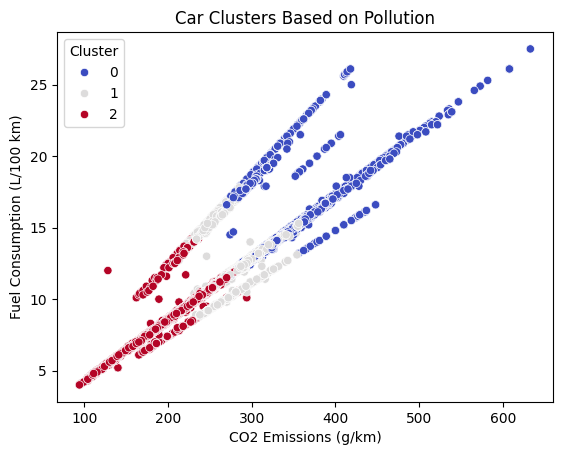

In [71]:
#features
features = ["CO2 emissions (g/km)", "Combined (L/100 km)", "Cylinders", "Engine size (L)"]

#data normalization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[features])

#K-Means
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df["Cluster"] = kmeans.fit_predict(df_scaled)

#visualize clusters
sns.scatterplot(x=df["CO2 emissions (g/km)"], y=df["Combined (L/100 km)"], hue=df["Cluster"], palette="coolwarm")
plt.xlabel("CO2 Emissions (g/km)")
plt.ylabel("Fuel Consumption (L/100 km)")
plt.title("Car Clusters Based on Pollution")
plt.show()

Assigning cluter labels

In [72]:
cluster_labels = {2: "Good (Low Pollution)", 1: "Moderate", 0: "Bad (High Pollution)"}
df["Cluster_Label"] = df["Cluster"].map(cluster_labels)

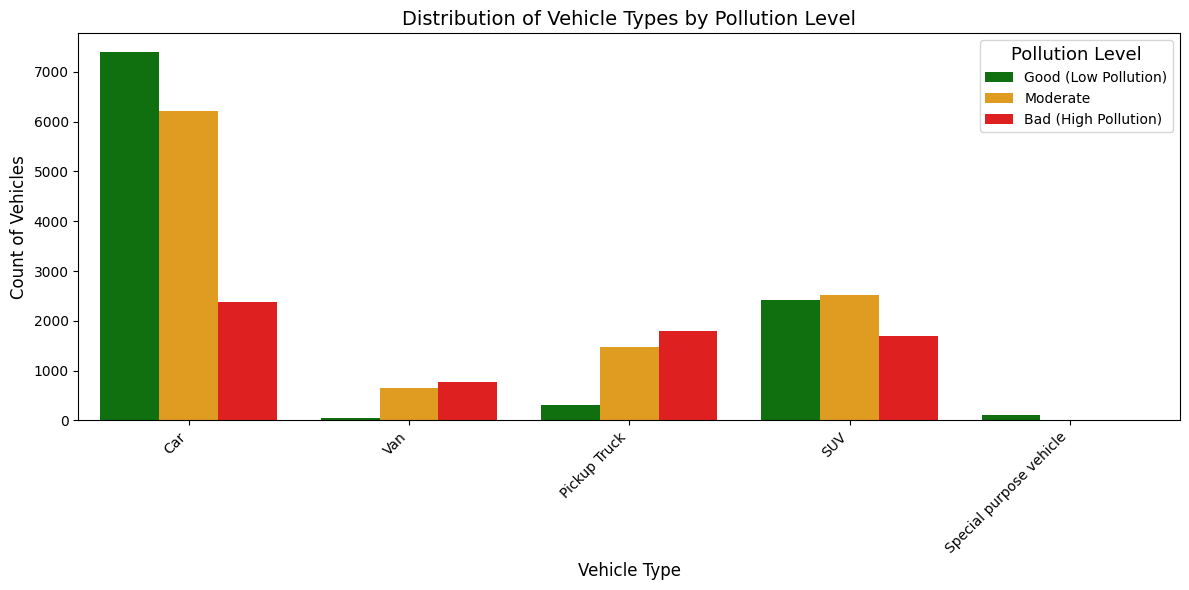

In [73]:
cluster_colors = {
    "Good (Low Pollution)": "green",
    "Moderate": "orange",
    "Bad (High Pollution)": "red"
}

plt.figure(figsize=(12, 6))

sns.countplot(data=df, x="Vehicle category", hue="Cluster_Label", palette=cluster_colors)

plt.xlabel("Vehicle Type", fontsize=12)
plt.ylabel("Count of Vehicles", fontsize=12)
plt.title("Distribution of Vehicle Types by Pollution Level", fontsize=14)

plt.xticks(rotation=45, ha="right")

plt.legend(title="Pollution Level", title_fontsize='13', labels=["Good (Low Pollution)", "Moderate", "Bad (High Pollution)"])

plt.tight_layout()
plt.show()

For cars, the majority fall into the Low and Moderate pollution categories, with the High pollution category representing the smallest group. In contrast, vans and pickup trucks are predominantly found in the Moderate and High pollution categories, with very few in the Low pollution category. SUVs show a higher concentration in the Moderate pollution category, followed by the Low pollution category, with some vehicles also falling into the High pollution group. Special purpose vehicles, on the other hand, have a relatively small representation, and the few that are present are primarily classified in the Low pollution category.

**Question 4) How have CO₂ emissions changed over time across different vehicle model years?**

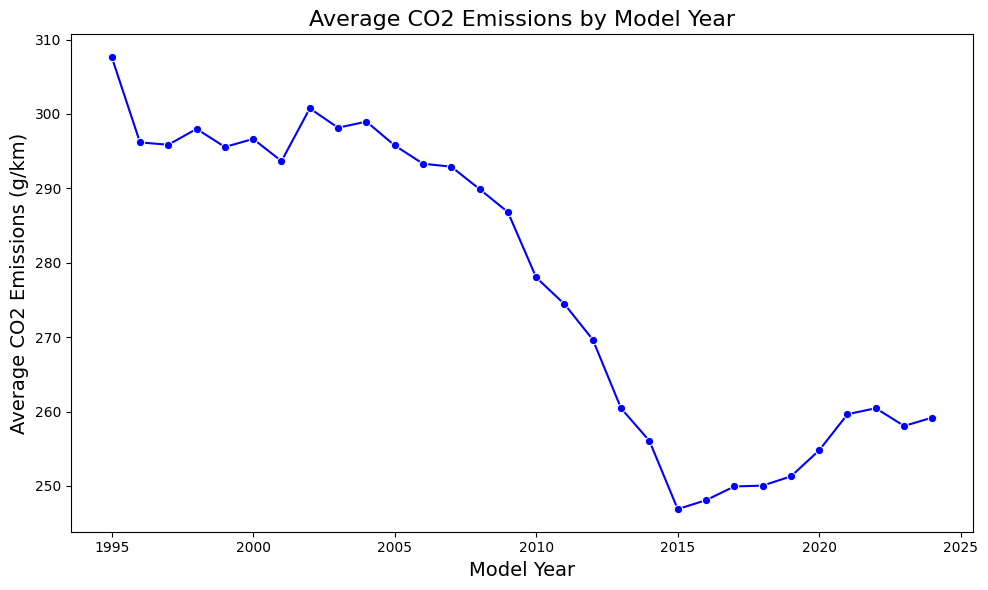

In [ ]:
mean_co2_by_year = df.groupby('Model.year')['CO2_emissions_gkm'].mean()

#line chart
plt.figure(figsize=(10, 6))
sns.lineplot(x=mean_co2_by_year.index, y=mean_co2_by_year.values, marker='o', color='blue')

plt.title('Average CO2 Emissions by Model Year', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Average CO2 Emissions (g/km)', fontsize=14)
plt.tight_layout()
plt.show()

The chart reveals a fluctuation in emissions from 1996 to 2004, followed by a decline from 2004 to 2015. However, there was an increase in emissions from 2015 to 2024, indicating a shift in emission trends over the years.